## Search and Destroy - Part 4

Search or motion each constitute a single `action'. 
Minimizing the actions incured while searching for the target.

In [0]:
# Import libraries

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import pprint as pp
import pandas as pd
from operator import itemgetter
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import pdb

## Environment


In [0]:
def place_target(env_terrains):
  a = env_terrains.shape[0] - 1

  i = random.randint(0,a)
  j = random.randint(0,a)
  
  return((i, j))

In [0]:
def generate_environment(a):

  env_terrains = np.zeros((a,a))

  for i in range(a):
    for j in range(a):
      terrain = random.random()
      
      if terrain < 0.2:
        env_terrains[i, j] = 5 #Flat terrain with p = 0.2
      elif terrain < 0.5:
        env_terrains[i, j] = 10 #Hilly terrain with p = 0.3
      elif terrain < 0.8:
        env_terrains[i, j] = 15 #Forested terrain with p = 0.3
      else:
        env_terrains[i, j] = 20 #Maze of caves with p = 0.2
  
  target_location = place_target(env_terrains)
  environment = (env_terrains, target_location)
  return environment

In [0]:
def display_grid(environment):
  env_grid = environment[0]
  target_location = environment[1]

  plt.figure(figsize = (8, 8))
  color_list = ['white', 'brown', 'green', 'gray']
  palette = sns.color_palette(color_list)
  ax = sns.heatmap(env_grid, annot = True,  linewidths = 0.01, linecolor = 'darkgray', cbar = False, xticklabels = True, yticklabels = True)
  ax.add_patch(Rectangle((target_location[1], target_location[0]), 1, 1, fill= False, capstyle = 'projecting', edgecolor='gold', linewidth = 4))
  plt.text(target_location[1] + 0.5, target_location[0] + 0.5, 'x', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 30, color = 'gold')
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show()

In [0]:
def search_cell(environment, cell):

  env_grid = environment[0]
  target_location = environment[1]

  if cell != target_location:
    return False

  else:
    if env_grid[cell] == 5:
      if random.random() < 0.9:
        return True
    elif env_grid[cell] == 10:
      if random.random() < 0.7:
        return True
    elif env_grid[cell] == 15:
      if random.random() < 0.3:
        return True
    elif env_grid[cell] == 20:
      if random.random() < 0.1:
        return True
    return False

#Agent

Function which updates the agent's belief of all the cells (belief of finding the target in the cell) whenever a cell is explored and the target is not found in the cell.

In [0]:
def update_belief(environment, prior_belief_map, cell_opened, false_negative_rate):
    
    dim = environment[0].shape[0]
    terrain = np.int(environment[0][cell_opened]/5)-1
    false_negative_cell_opened = false_negative_rate[terrain]
    
    denominator = (prior_belief_map[cell_opened] * (false_negative_cell_opened)) + (1 - prior_belief_map[cell_opened])

    update_belief_map = prior_belief_map/denominator
    update_belief_map[cell_opened] = update_belief_map[cell_opened] * (false_negative_cell_opened)

    return update_belief_map

Approaches for selecting the cell to search based on belief map and false negative rate of terrain of the cell:

In [0]:
def rule_1(belief_map):
  cell_index = np.unravel_index(np.argmax(belief_map, axis=None), belief_map.shape)
  return cell_index

In [0]:
def rule_2(environment, belief_map, false_negative_rate):
  
  false_negative_matrix = environment[0]/5
  for x in range(1,5):
   false_negative_matrix[false_negative_matrix == x] = (1 - false_negative_rate[x-1])

  new_probability = np.multiply(false_negative_matrix, belief_map)
  cell_index = np.unravel_index(np.random.choice(np.flatnonzero(new_probability == new_probability.max())), belief_map.shape)
  return cell_index

In [0]:
def compute_actions(current_cell, target_cell):
  # +1 for searching it
  return abs(current_cell[0]- target_cell[0]) + abs(current_cell[1]- target_cell[1]) + 1 

Functions to optimize the search for target by definig a cost function to minimize the number of actions: 

In [0]:
def compute_cost_one_step(environment, belief_map, current_cell, false_negative_rate):
  
  env_grid = environment[0]
  a = env_grid.shape[0]
  min_cost_so_far = float('inf')
  cell_with_min_cost = (0,0)
  cost_matrix = np.full((a, a), 0.0)

  for i in range(a):
    for j in range(a):
      # manhattan_distance
      distance = (abs(current_cell[0]-i) + abs(current_cell[1]-j))
      if (i,j) == current_cell:
        distance += 0.5 * (2 * a)
      terrain = np.int(env_grid[(i,j)]/5)-1
      false_negative_cell_opened = false_negative_rate[terrain]
      if belief_map[i][j] != 0:
        cost = distance/(2 * a) + (1 - (belief_map[i][j]*(1-false_negative_cell_opened))) + 1
      cost_matrix[i][j] = cost

  min_cell = np.unravel_index(np.random.choice(np.flatnonzero(cost_matrix == cost_matrix.min())), cost_matrix.shape)
  actions =  compute_actions(current_cell, min_cell)
  return min_cell, actions, cost_matrix[min_cell]

In [0]:
def simplified_two_step_cost(environment, belief_map, current_cell, false_negative_rate):

  env_grid = environment[0]
  a = env_grid.shape[0]

  min_cost_so_far = float('inf')
  min_first_cell = (0,0)
  min_second_cell = (0,0)
  
  cost_matrix = np.full((a,a), 10000.0)

  for i in range(a):
    for j in range(a):
      if(i!=current_cell[0] or j!=current_cell[1]):
        first_cell = (i,j)
        distance_from_current_to_first = abs(current_cell[0]-i) + abs(current_cell[1]-j)
        terrain = np.int(env_grid[first_cell]/5)-1
        false_negative_cell_opened = false_negative_rate[terrain]
        ## Cost from current cell to first cell (i,j)
        cost_1 = distance_from_current_to_first/ (2 * a) + 1 
        p_1 = 1 - (belief_map[first_cell]*(1 - false_negative_cell_opened))
        temp_belief_map = np.full((a,a), 0)
        temp_belief_map = update_belief(environment, belief_map, first_cell, false_negative_rate)
        min_cell, min_actions, min_cost = compute_cost_one_step(environment, temp_belief_map, first_cell, false_negative_rate)
        total_expected_cost = cost_1 + p_1*min_cost

        if(min_cost_so_far > total_expected_cost):
          min_cost_so_far = total_expected_cost

        cost_matrix[(i, j)] = round(total_expected_cost,2)

  min_first_cell = np.unravel_index(np.random.choice(np.flatnonzero(cost_matrix == cost_matrix.min())), cost_matrix.shape)
  # print("Min_cost = ", cost_matrix[min_first_cell])
  # print("First cell = ", min_first_cell )
  # print("Cost Matrix:")
  # pp.pprint(cost_matrix)
  # display_grid((cost_matrix, min_first_cell))
  actions = compute_actions(current_cell, min_first_cell)
  return min_first_cell, actions, min_cost_so_far

In [0]:
def compute_cost_two_steps(environment, belief_map, current_cell,false_negative_rate):

  env_grid = environment[0]
  a = env_grid.shape[0]

  min_cost_so_far = float('inf')
  min_first_cell = (0,0)
  min_second_cell = (0,0)
  
  cost_matrix = np.full((a,a), 10000.0)
  second_cells = [[(-1, -1) for i in range(a)] for j in range(a)]

  for i in range(a):
    for j in range(a):
      if(i!=current_cell[0] or j!=current_cell[1]):
        first_cell = (i,j)
        distance_from_current_to_first = abs(current_cell[0]-i) + abs(current_cell[1]-j)
        terrain = np.int(env_grid[first_cell]/5)-1
        false_negative_cell_opened = false_negative_rate[terrain]
        ## Cost from current cell to first cell (i,j)
        cost_1 = distance_from_current_to_first/ (2 * a) + 1 
        p_1 = 1 - (belief_map[first_cell]*(1 - false_negative_cell_opened))
        
        min_cost_so_far = float('inf')
        for m in range(a):
          for n in range(a):
            if(m!=i or n!=j) and (m!=current_cell[0] or n!=current_cell[1]):
              temp_belief_map = np.full((a,a), 0)
              temp_belief_map = update_belief(environment, belief_map, first_cell, false_negative_rate) 
              second_cell = (m,n)
              distance_from_first_to_second = (abs(i-m) + abs(j-n))
              terrain = np.int(env_grid[second_cell]/5)-1
              false_negative_cell_opened = false_negative_rate[terrain]
              ## Expected cost from second cell to any other future step
              temp_belief_map_2 = update_belief(environment, temp_belief_map, second_cell, false_negative_rate)
              # min_cell, min_actions, min_cost = compute_cost_one_step(environment, temp_belief_map_2, second_cell, false_negative_rate)
              cost_2 = (distance_from_first_to_second/ (2 * a)) + 1 + (1 - (temp_belief_map[second_cell]*(1 - false_negative_cell_opened))) #*min1_cost

              total_expected_cost = cost_1 + p_1*cost_2

              if(min_cost_so_far > total_expected_cost):
                min_cost_so_far = total_expected_cost
                min_second_cell = second_cell

        cost_matrix[(i, j)] = round(min_cost_so_far,2)
        second_cells[i][j] = min_second_cell

  min_first_cell = np.unravel_index(np.random.choice(np.flatnonzero(cost_matrix == cost_matrix.min())), cost_matrix.shape)
  # print("Min_cost = ", cost_matrix[min_first_cell])
  # print("First cell = ", min_first_cell)
  # print("Second cell = ", second_cells[min_first_cell[0]][min_first_cell[1]])
  # print("Cost Matrix:")
  # pp.pprint(cost_matrix)
  # display_grid((cost_matrix, min_first_cell))
  actions = compute_actions(current_cell, min_first_cell)
  return min_first_cell, actions, min_cost_so_far

Here, the agent follows one of the above defined rules to select the next cell to search for at every step based on the updated belief map and the terrain of the cell. The 'rule_number' parameter determines the rule followed by the agent.

In [0]:
def agent(environment,rule_number):

  env_grid = environment[0]
  a = env_grid.shape[0]

  prior_belief = 1/(a*a)
  belief_map = np.full((a,a), prior_belief)

  false_negative_rate = [0.1, 0.3, 0.7, 0.9]
  total_actions = 1
  
  # picking a cell at random to start with 
  i = random.randint(0, a-1)
  j = random.randint(0, a-1)
  current_cell = (i,j)

  while(True): 
    # print(current_cell)
    is_target = search_cell(environment, current_cell)
    if(is_target):
      return total_actions
    else:
      belief_map = update_belief(environment, belief_map, current_cell, false_negative_rate) 

    ## Rule number mapping: 
    ## 0 - Rule 1
    ## 1 - Rule 2
    ## 2 - One step estimated cost
    ## 3 - Simplified Two step estimated cost
    ## 4 - Two step estimated cost

    if rule_number == 0:
      new_cell = rule_1(belief_map)
      actions = compute_actions(current_cell, new_cell)
      current_cell = new_cell
    elif rule_number == 1:
      new_cell = rule_2(environment, belief_map, false_negative_rate)
      actions = compute_actions(current_cell, new_cell)
      current_cell = new_cell
    elif rule_number == 2:
      current_cell, actions, min_cost = compute_cost_one_step(environment, belief_map, current_cell,false_negative_rate)
    elif rule_number == 3:
      current_cell, actions, min_cost = simplified_two_step_cost(environment, belief_map, current_cell,false_negative_rate)
    elif rule_number == 4:
      current_cell, actions, min_cost = compute_cost_two_steps(environment, belief_map, current_cell,false_negative_rate)
    
    
    total_actions = total_actions + actions

  return total_actions

## Testing one step estimator and two step estimator

Terrain of Target: 1


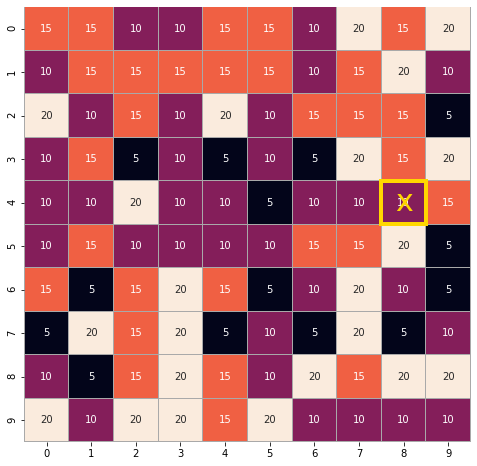

 One step estimation: 
Total actions= 149
Time: 0.045262813568115234
Terrain of Target: 1


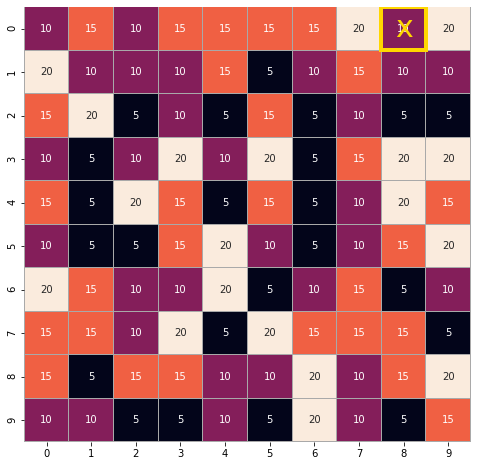

 One step estimation: 
Total actions= 95
Time: 0.02921605110168457
Terrain of Target: 0


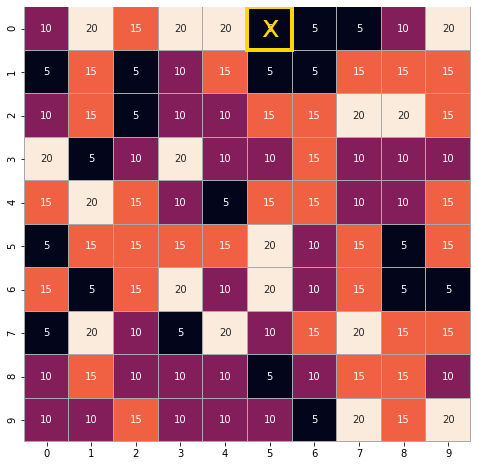

 One step estimation: 
Total actions= 53
Time: 0.016620874404907227
Terrain of Target: 2


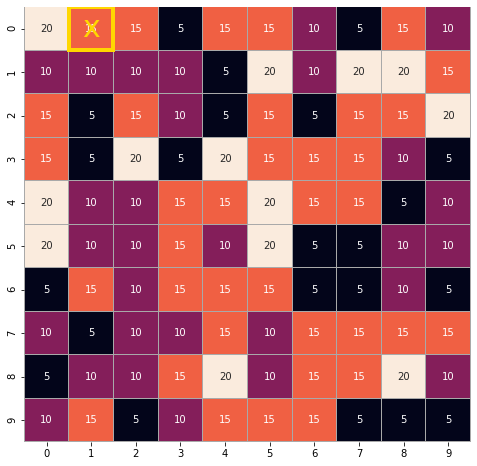

 One step estimation: 
Total actions= 467
Time: 0.14660000801086426
Terrain of Target: 2


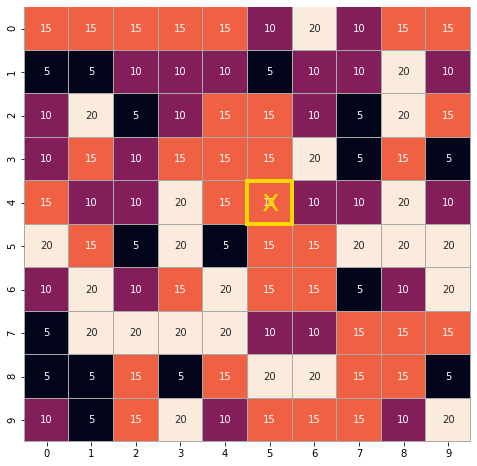

 One step estimation: 
Total actions= 1585
Time: 0.4927072525024414
Terrain of Target: 1


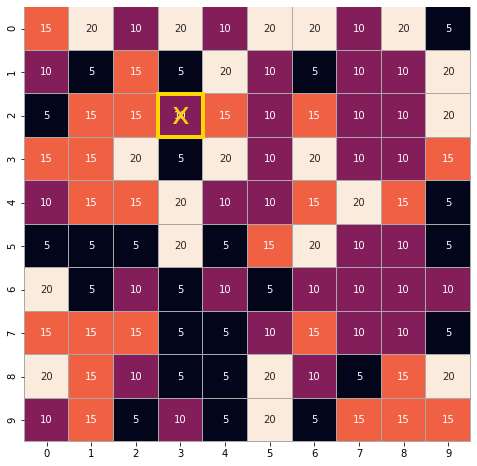

 One step estimation: 
Total actions= 89
Time: 0.02608656883239746
Terrain of Target: 2


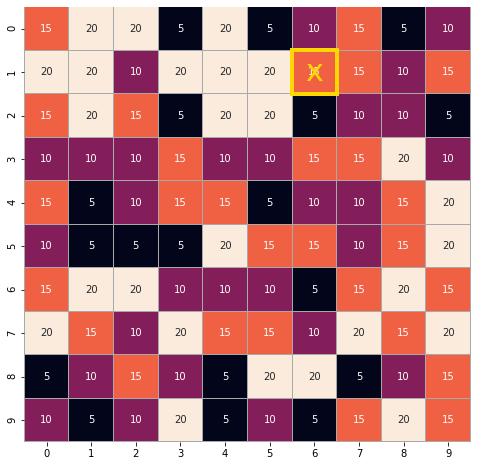

 One step estimation: 
Total actions= 413
Time: 0.12297630310058594
Terrain of Target: 0


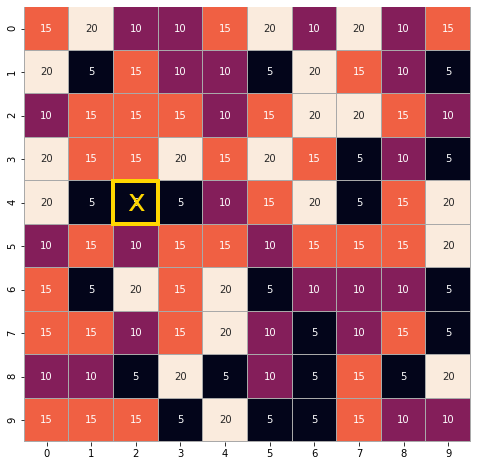

 One step estimation: 
Total actions= 15
Time: 0.0046231746673583984
Terrain of Target: 1


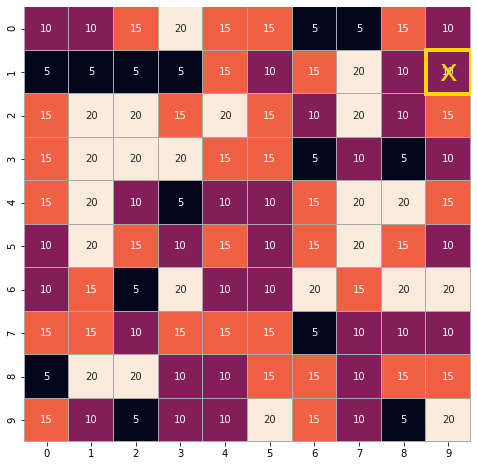

 One step estimation: 
Total actions= 157
Time: 0.052378177642822266
Terrain of Target: 2


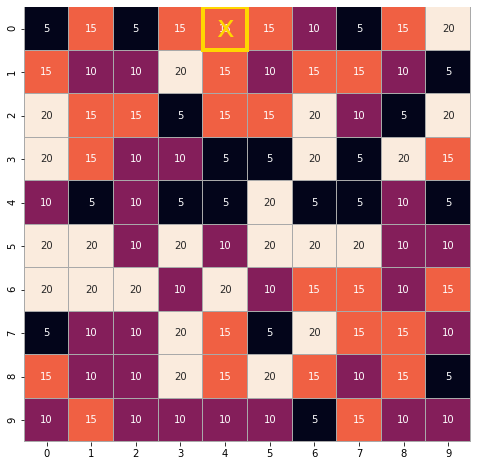

 One step estimation: 
Total actions= 609
Time: 0.18503332138061523
Terrain of Target: 0


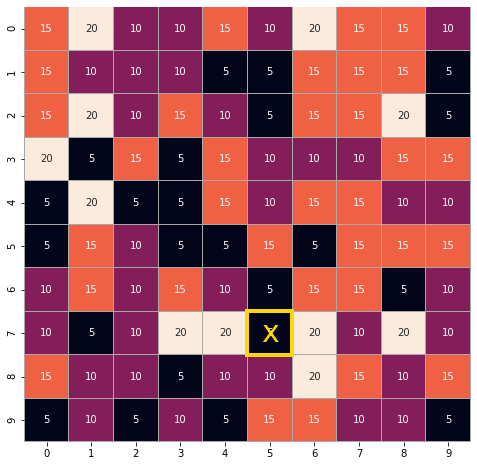

 One step estimation: 
Total actions= 45
Time: 0.013677120208740234
Terrain of Target: 1


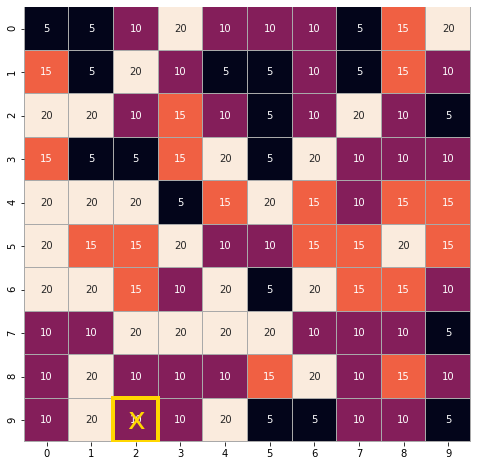

 One step estimation: 
Total actions= 231
Time: 0.07181334495544434
Terrain of Target: 1


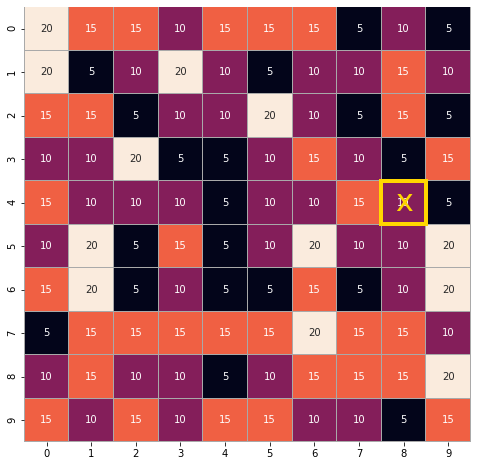

 One step estimation: 
Total actions= 45
Time: 0.013871192932128906
Terrain of Target: 1


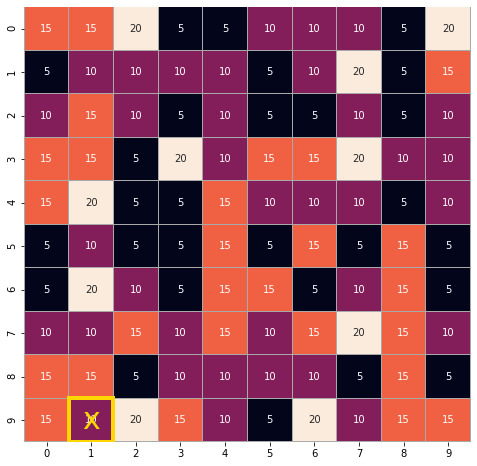

 One step estimation: 
Total actions= 219
Time: 0.06703519821166992
Terrain of Target: 1


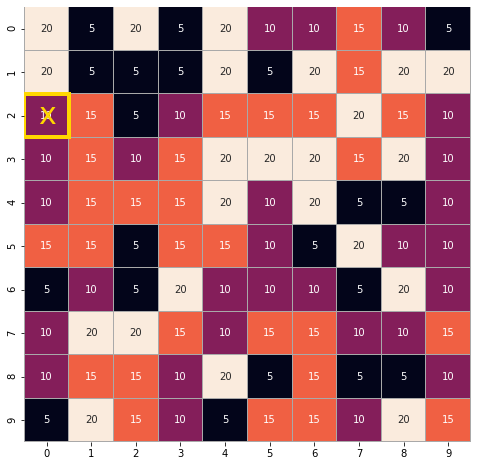

 One step estimation: 
Total actions= 275
Time: 0.0861506462097168
Terrain of Target: 1


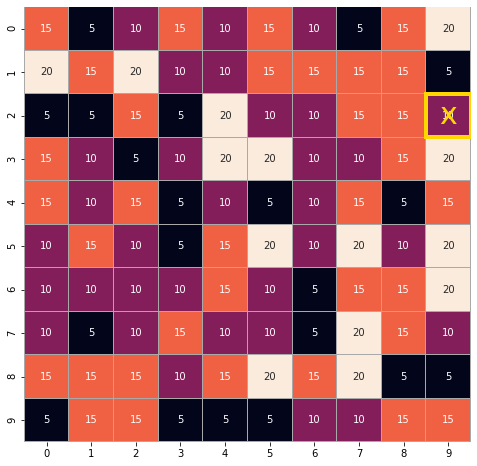

 One step estimation: 
Total actions= 201
Time: 0.061982154846191406
Terrain of Target: 3


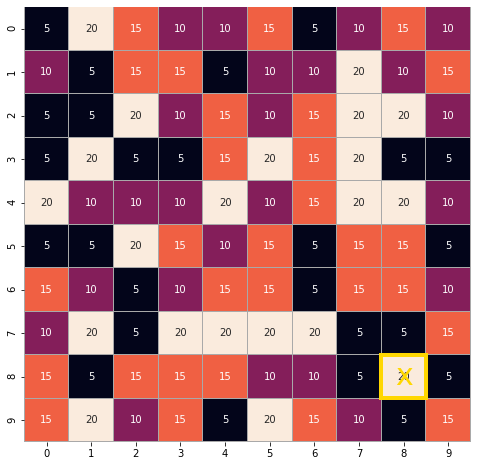

 One step estimation: 
Total actions= 2801
Time: 0.8390762805938721
Terrain of Target: 1


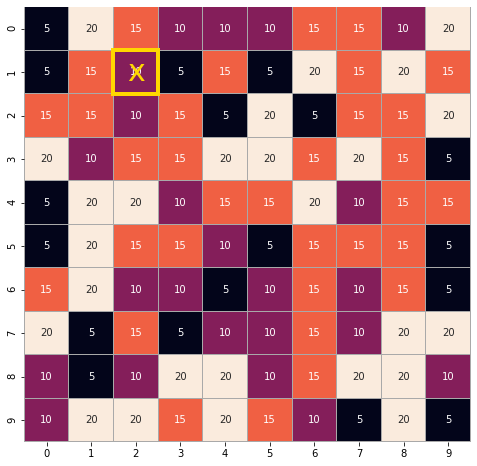

 One step estimation: 
Total actions= 111
Time: 0.03271198272705078
Terrain of Target: 1


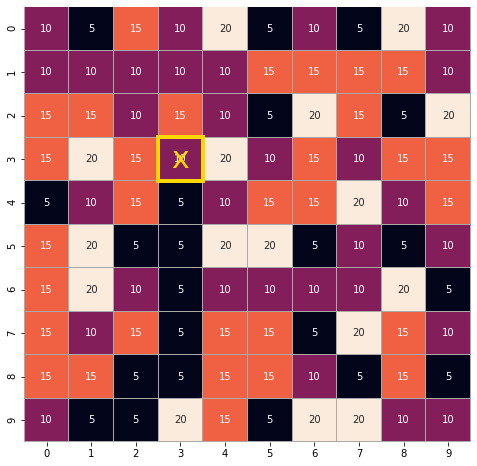

 One step estimation: 
Total actions= 353
Time: 0.11363363265991211
Terrain of Target: 3


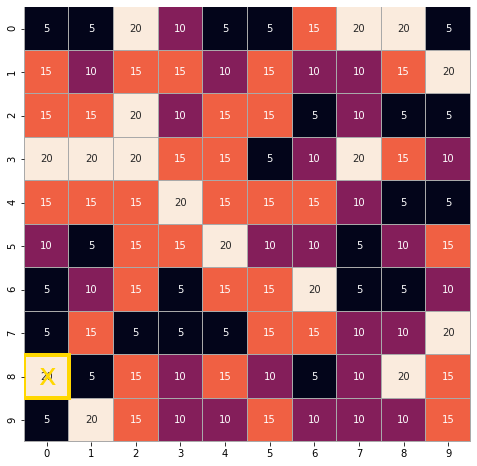

 One step estimation: 
Total actions= 327
Time: 0.09937405586242676
Terrain of Target: 1


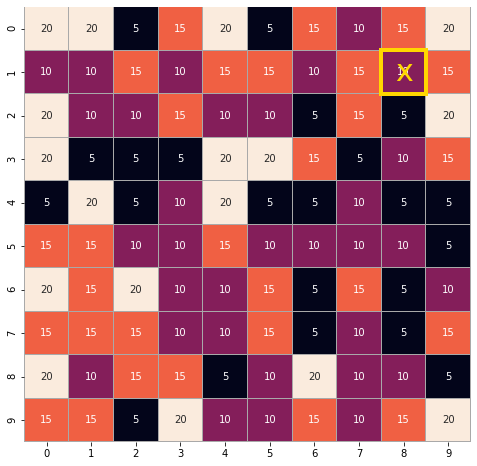

 One step estimation: 
Total actions= 167
Time: 0.052880048751831055
Terrain of Target: 3


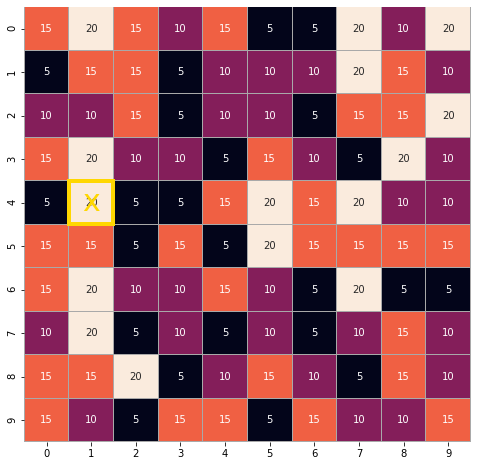

 One step estimation: 
Total actions= 347
Time: 0.10687136650085449
Terrain of Target: 2


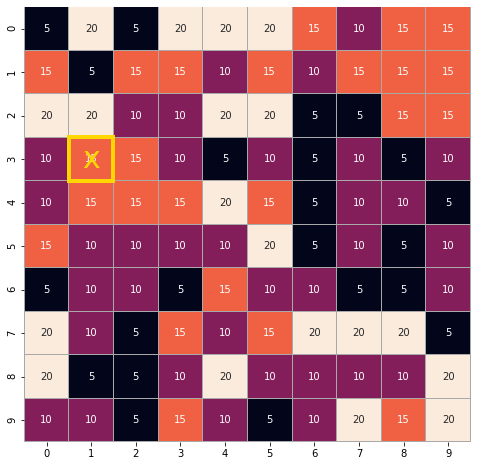

 One step estimation: 
Total actions= 145
Time: 0.05002117156982422
Terrain of Target: 0


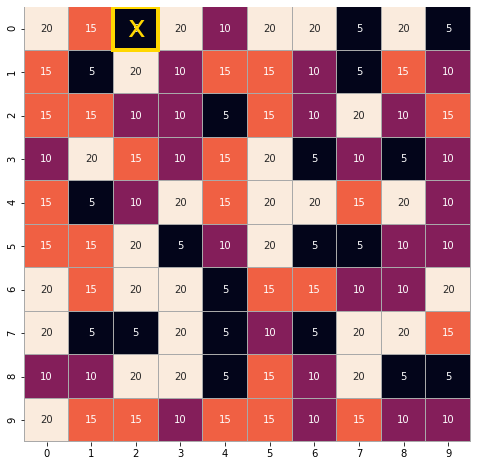

 One step estimation: 
Total actions= 187
Time: 0.05796647071838379
Terrain of Target: 3


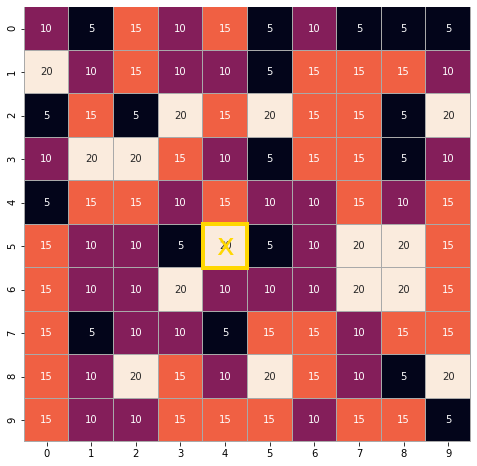

 One step estimation: 
Total actions= 677
Time: 0.20760750770568848
Terrain of Target: 1


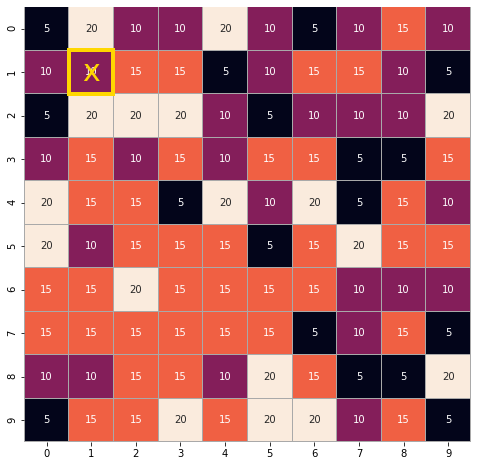

 One step estimation: 
Total actions= 223
Time: 0.07552385330200195
Terrain of Target: 2


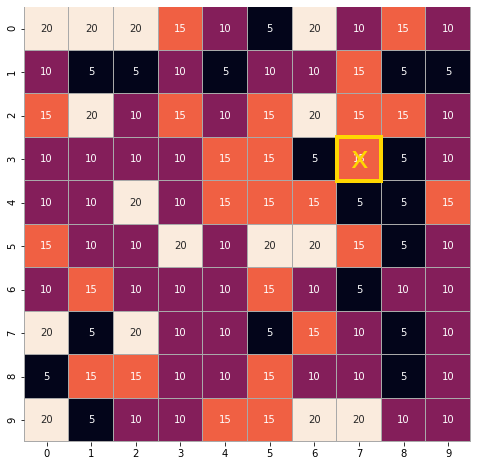

 One step estimation: 
Total actions= 141
Time: 0.0475001335144043
Terrain of Target: 2


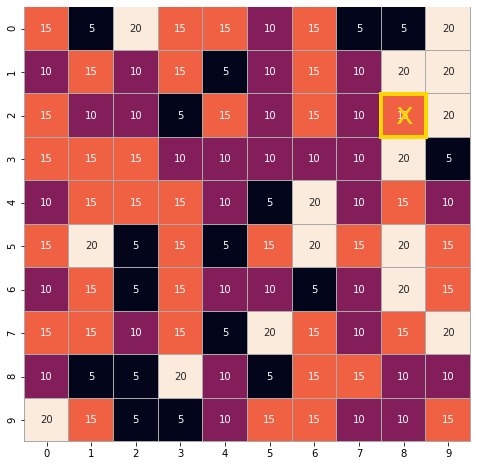

 One step estimation: 
Total actions= 541
Time: 0.16242051124572754
Terrain of Target: 2


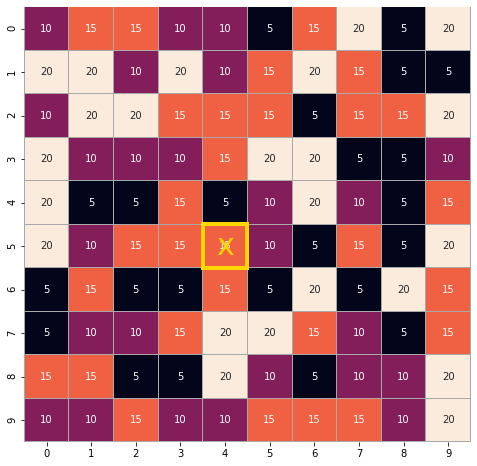

 One step estimation: 
Total actions= 1441
Time: 0.4416236877441406
Terrain of Target: 3


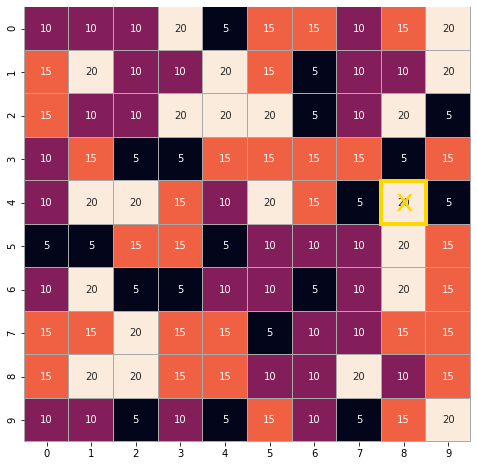

 One step estimation: 
Total actions= 443
Time: 0.1402294635772705
Terrain of Target: 1


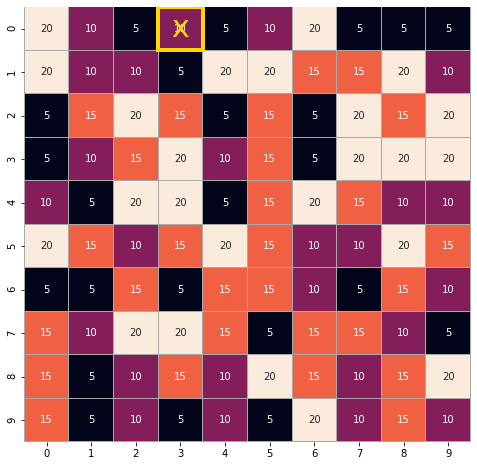

 One step estimation: 
Total actions= 241
Time: 0.07192635536193848
Terrain of Target: 0


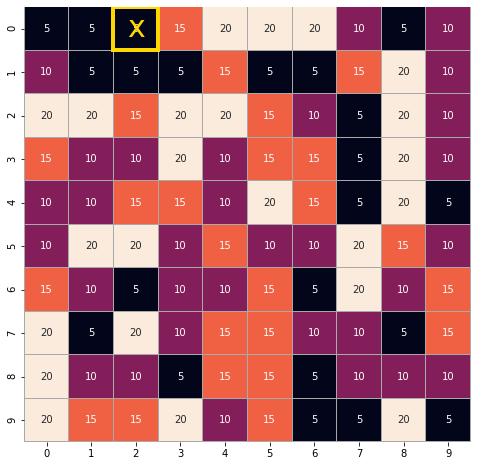

 One step estimation: 
Total actions= 381
Time: 0.11731791496276855
Terrain of Target: 3


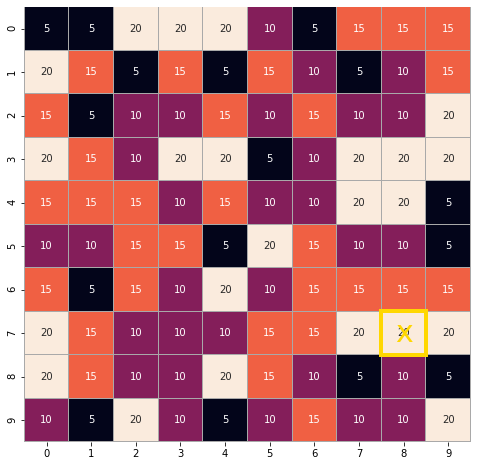

 One step estimation: 
Total actions= 579
Time: 0.1852412223815918
Terrain of Target: 1


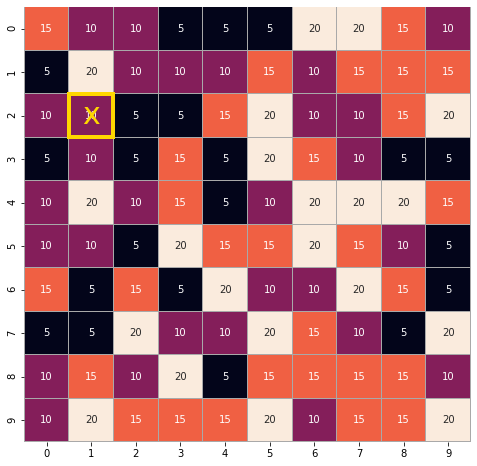

 One step estimation: 
Total actions= 237
Time: 0.0727682113647461
Terrain of Target: 3


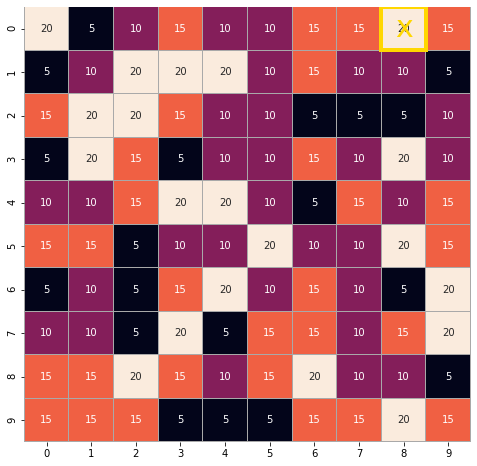

 One step estimation: 
Total actions= 1295
Time: 0.3882408142089844
Terrain of Target: 1


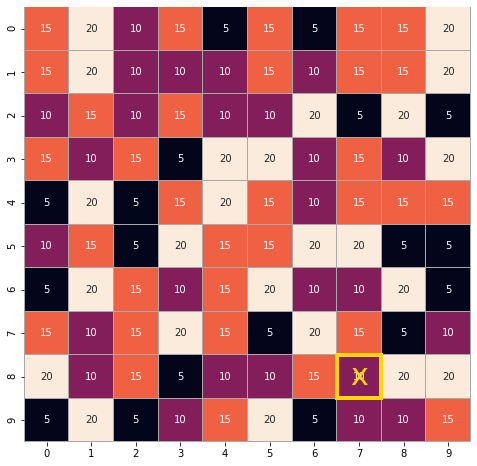

 One step estimation: 
Total actions= 215
Time: 0.06443476676940918
Terrain of Target: 3


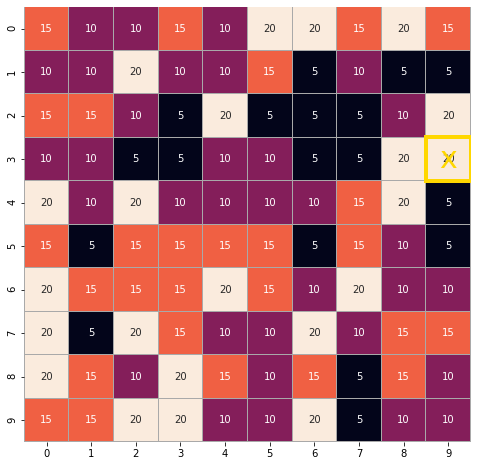

 One step estimation: 
Total actions= 1501
Time: 0.464017391204834
Terrain of Target: 2


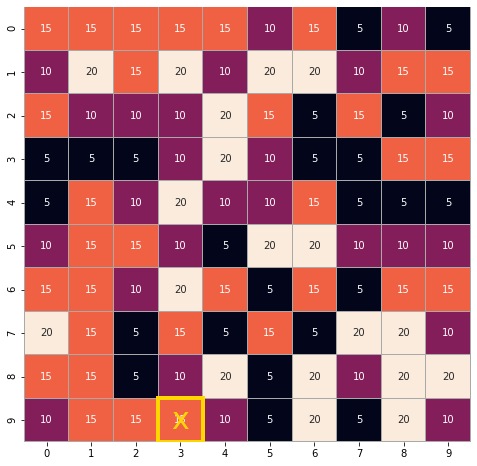

 One step estimation: 
Total actions= 3097
Time: 0.9593350887298584
Terrain of Target: 2


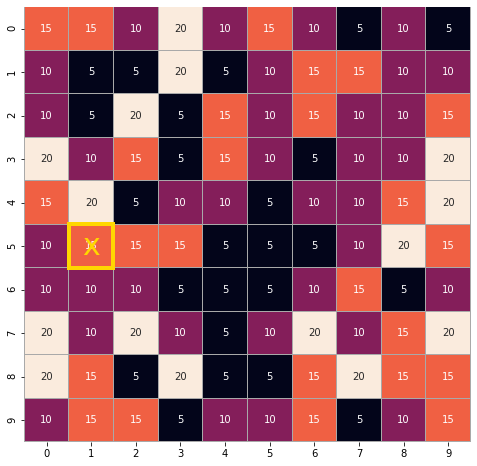

 One step estimation: 
Total actions= 381
Time: 0.11513090133666992
Terrain of Target: 0


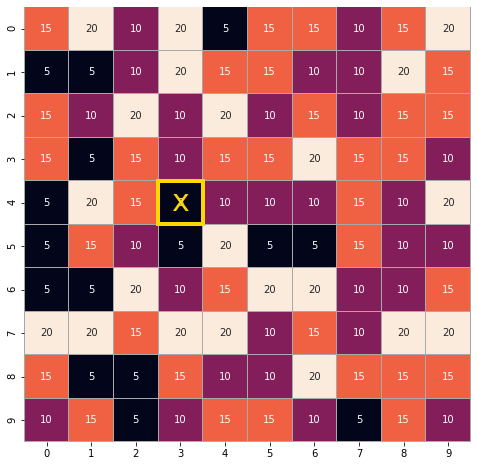

 One step estimation: 
Total actions= 163
Time: 0.06036186218261719
Terrain of Target: 3


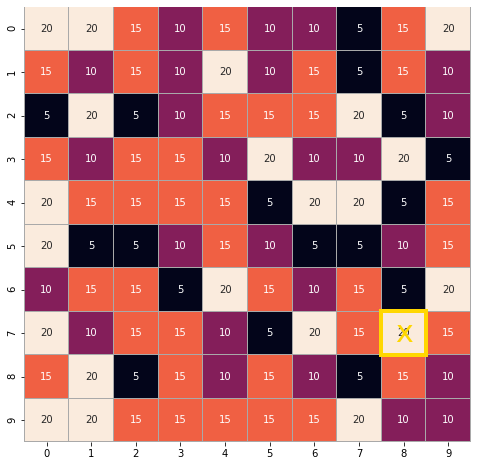

 One step estimation: 
Total actions= 1211
Time: 0.36953163146972656
Terrain of Target: 3


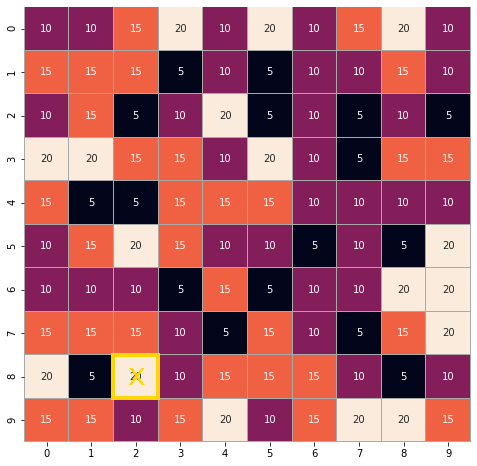

 One step estimation: 
Total actions= 2899
Time: 0.9136548042297363
Terrain of Target: 1


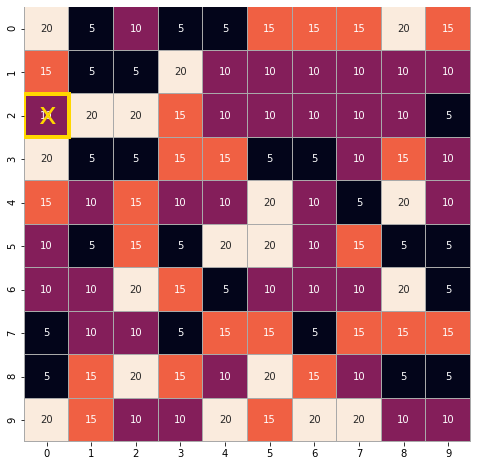

 One step estimation: 
Total actions= 213
Time: 0.06690335273742676
Terrain of Target: 1


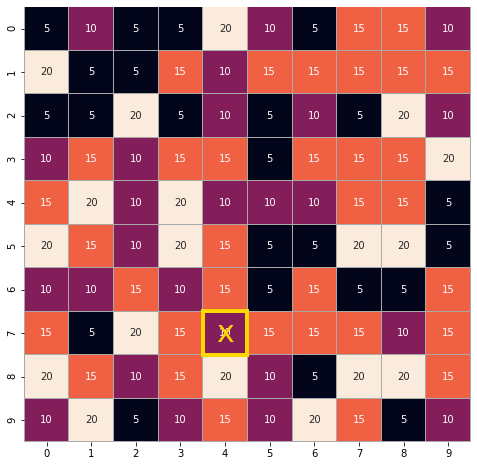

 One step estimation: 
Total actions= 95
Time: 0.028021812438964844
Terrain of Target: 1


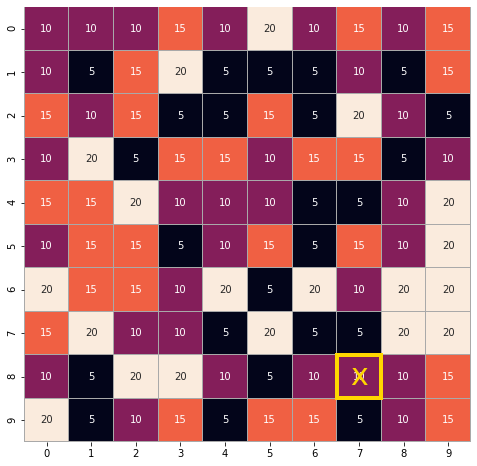

 One step estimation: 
Total actions= 347
Time: 0.11463332176208496
Terrain of Target: 1


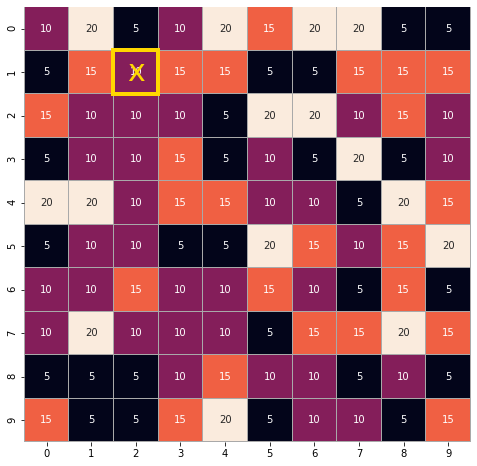

 One step estimation: 
Total actions= 89
Time: 0.027034997940063477
Terrain of Target: 2


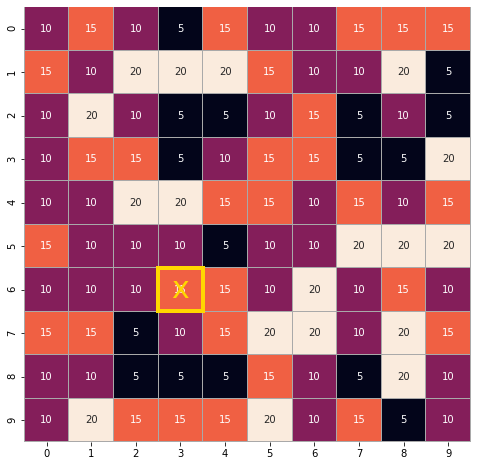

 One step estimation: 
Total actions= 297
Time: 0.08925390243530273
Terrain of Target: 2


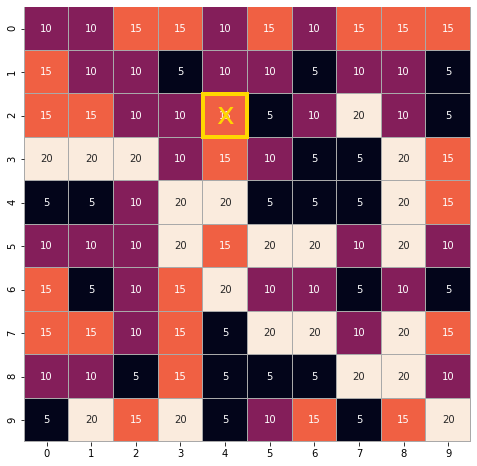

 One step estimation: 
Total actions= 401
Time: 0.12202286720275879
Terrain of Target: 1


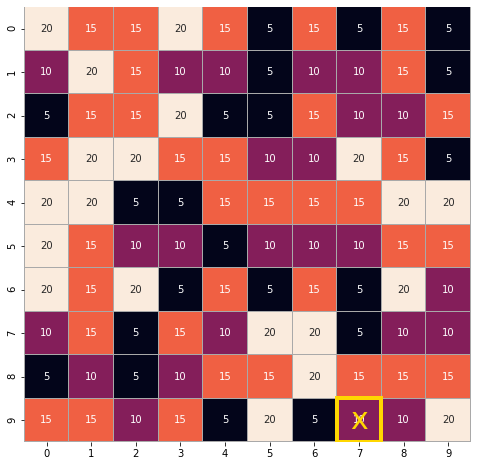

 One step estimation: 
Total actions= 157
Time: 0.04907822608947754
Terrain of Target: 0


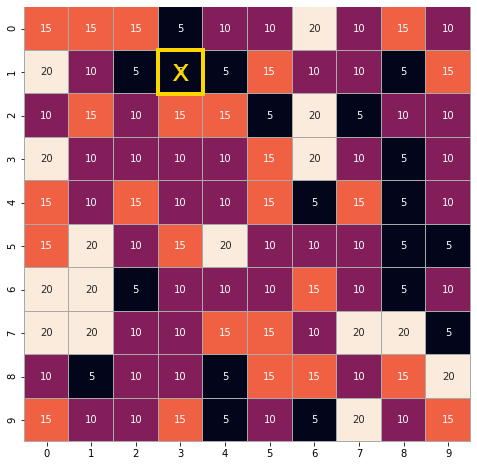

 One step estimation: 
Total actions= 313
Time: 0.09853315353393555
Terrain of Target: 3


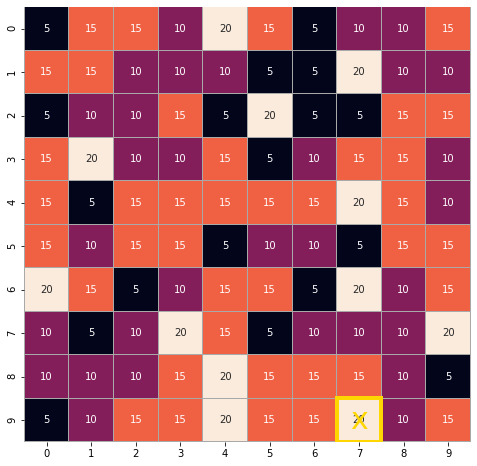

 One step estimation: 
Total actions= 875
Time: 0.28035950660705566
Terrain of Target: 1


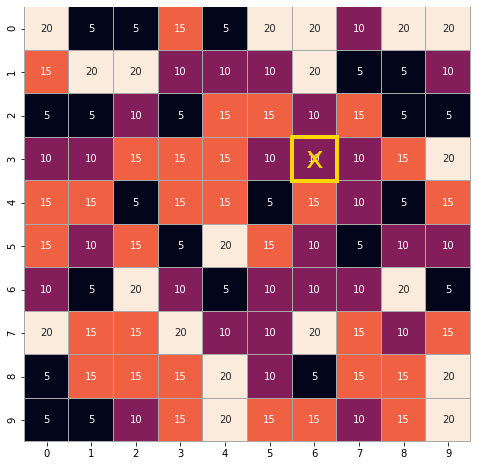

 One step estimation: 
Total actions= 361
Time: 0.10817313194274902
Terrain of Target: 3


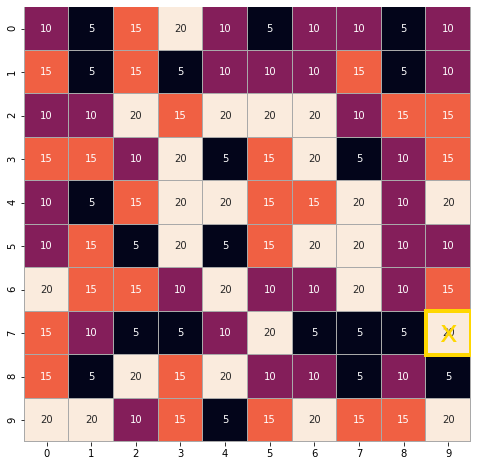

 One step estimation: 
Total actions= 843
Time: 0.27431797981262207
Terrain of Target: 0


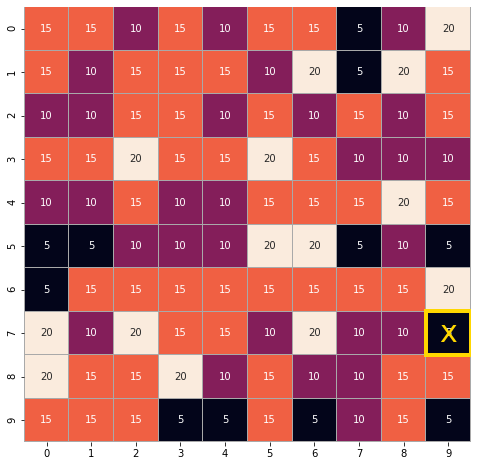

 One step estimation: 
Total actions= 295
Time: 0.08925962448120117
Terrain of Target: 2


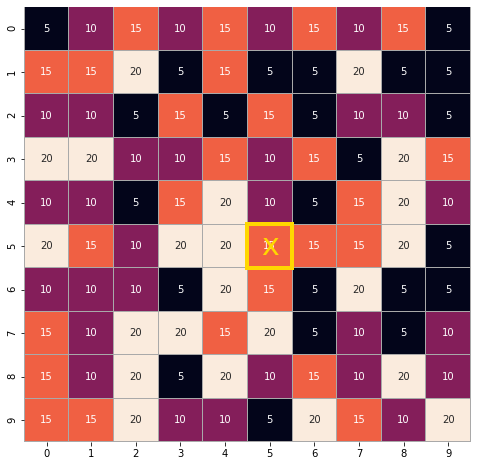

 One step estimation: 
Total actions= 113
Time: 0.03315925598144531
Terrain of Target: 1


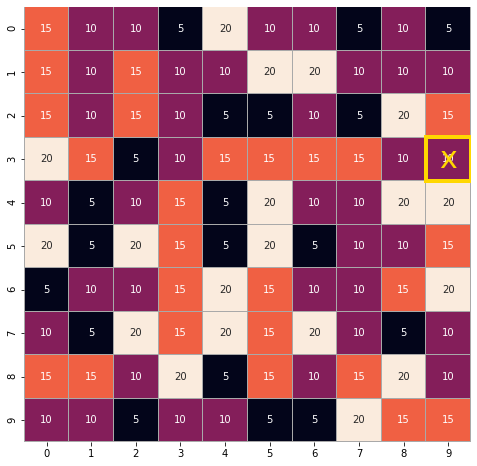

 One step estimation: 
Total actions= 101
Time: 0.03104996681213379
Terrain of Target: 1


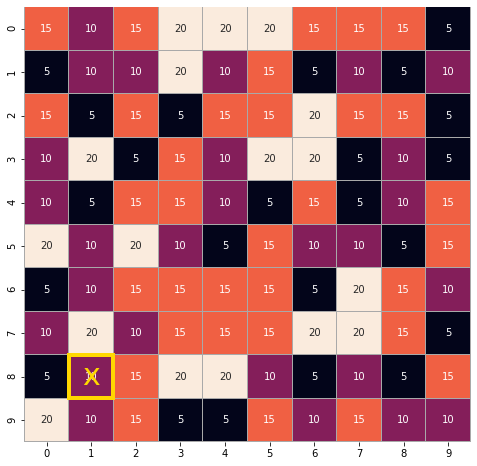

 One step estimation: 
Total actions= 95
Time: 0.03139686584472656
Terrain of Target: 0


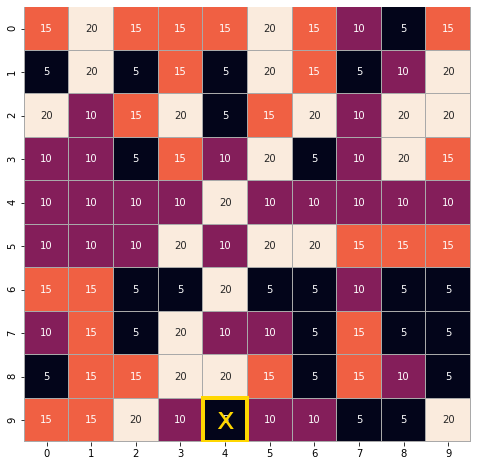

 One step estimation: 
Total actions= 557
Time: 0.1742842197418213
Terrain of Target: 3


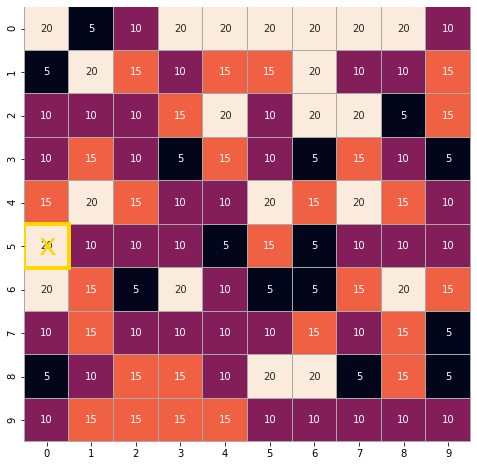

 One step estimation: 
Total actions= 401
Time: 0.12364554405212402
Terrain of Target: 2


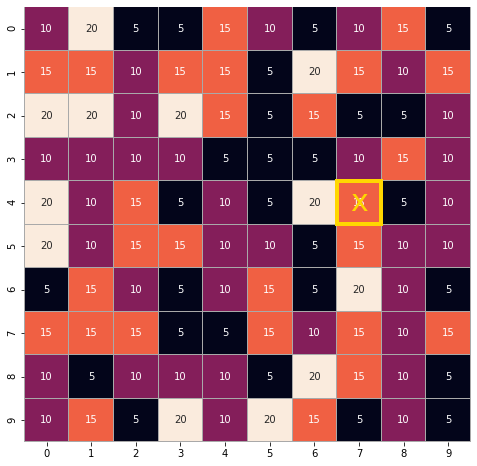

 One step estimation: 
Total actions= 295
Time: 0.09313750267028809
Terrain of Target: 1


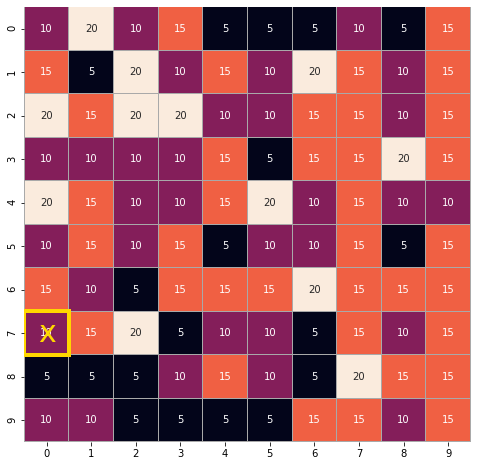

 One step estimation: 
Total actions= 131
Time: 0.03962373733520508
Terrain of Target: 3


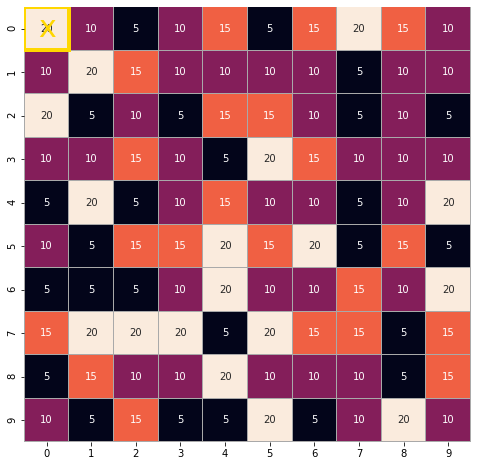

 One step estimation: 
Total actions= 1051
Time: 0.33361148834228516
Terrain of Target: 0


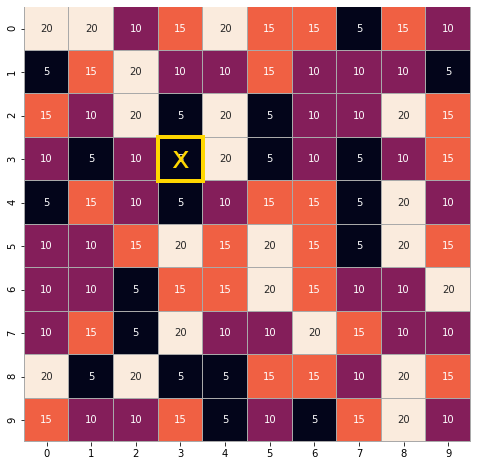

 One step estimation: 
Total actions= 77
Time: 0.02627253532409668
Terrain of Target: 3


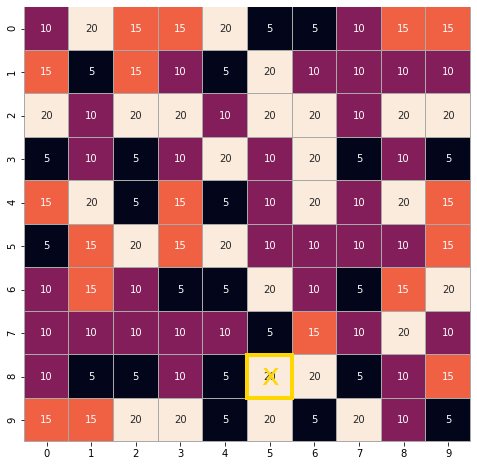

 One step estimation: 
Total actions= 1073
Time: 0.3438429832458496
Terrain of Target: 0


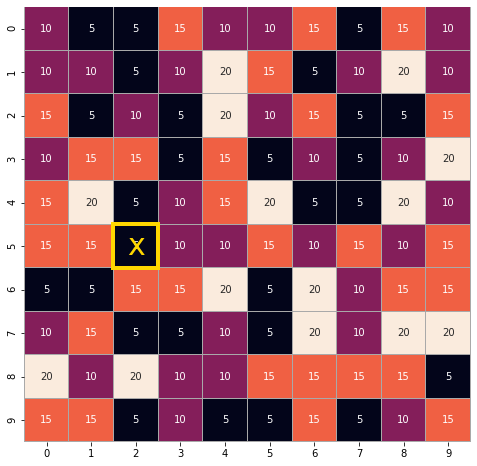

 One step estimation: 
Total actions= 31
Time: 0.013955116271972656
Terrain of Target: 2


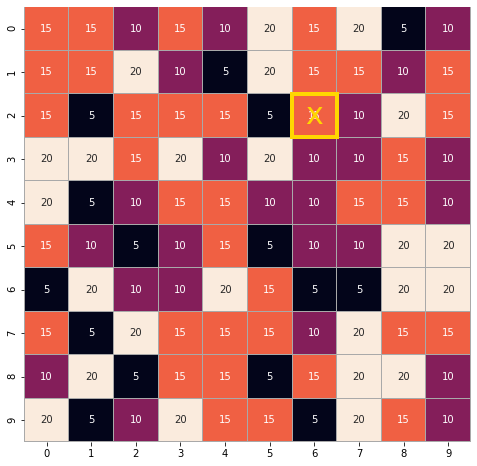

 One step estimation: 
Total actions= 333
Time: 0.10599780082702637
Terrain of Target: 1


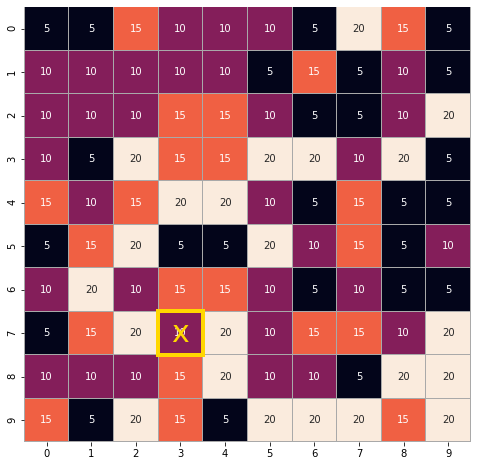

 One step estimation: 
Total actions= 159
Time: 0.048673391342163086
Terrain of Target: 3


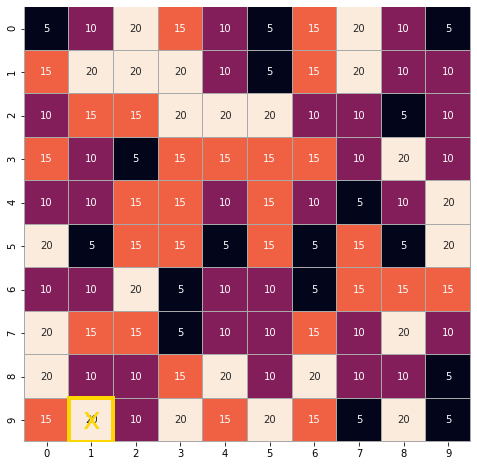

 One step estimation: 
Total actions= 519
Time: 0.15030884742736816
Terrain of Target: 1


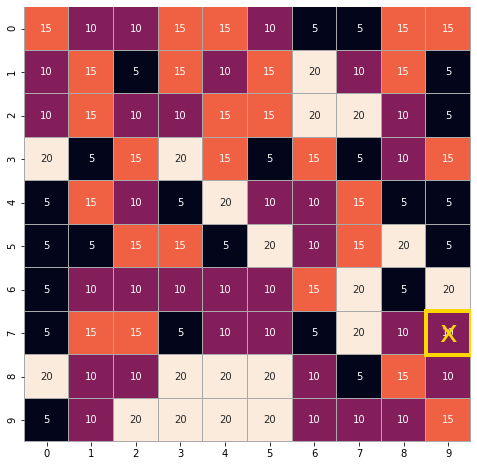

 One step estimation: 
Total actions= 107
Time: 0.035129547119140625
Terrain of Target: 1


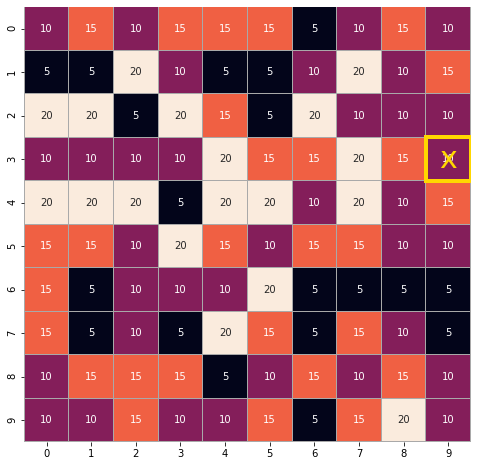

 One step estimation: 
Total actions= 389
Time: 0.11242485046386719
Terrain of Target: 1


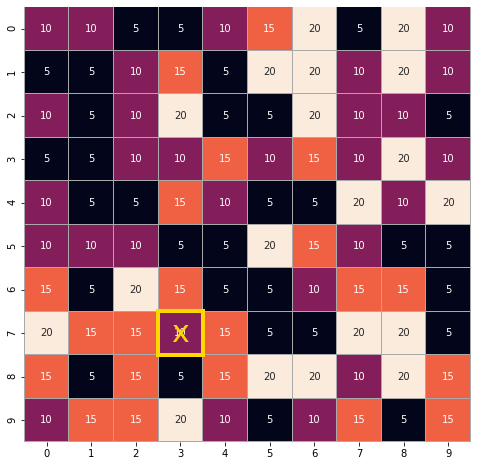

 One step estimation: 
Total actions= 75
Time: 0.026053905487060547
Terrain of Target: 0


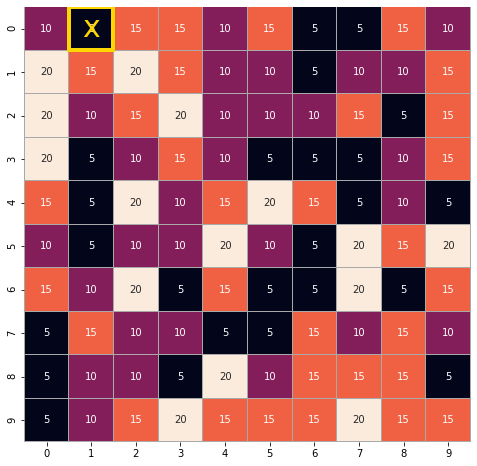

 One step estimation: 
Total actions= 293
Time: 0.09313654899597168
Terrain of Target: 0


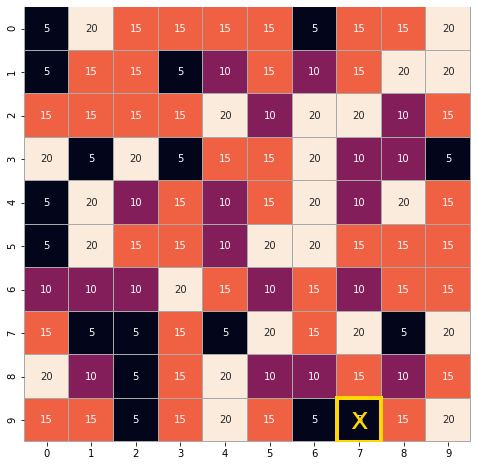

 One step estimation: 
Total actions= 111
Time: 0.03870439529418945
Terrain of Target: 3


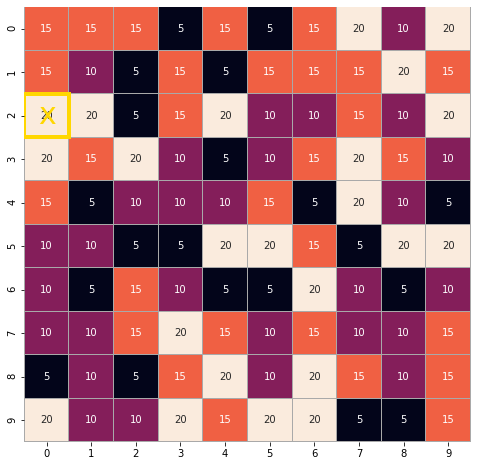

 One step estimation: 
Total actions= 1097
Time: 0.320587158203125
Terrain of Target: 3


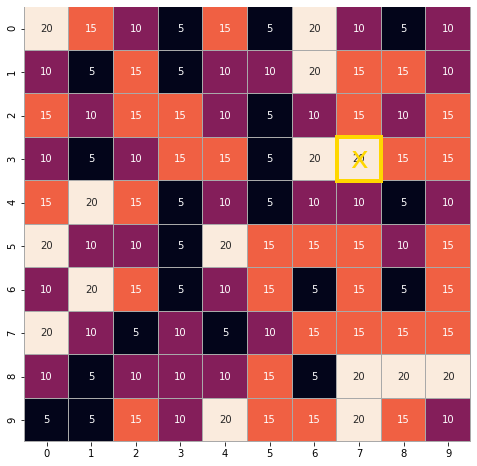

 One step estimation: 
Total actions= 827
Time: 0.2364349365234375
Terrain of Target: 0


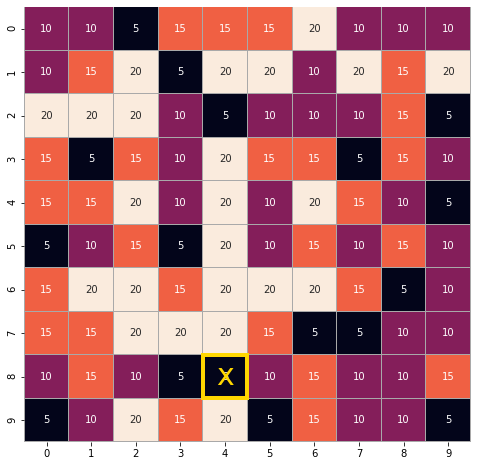

 One step estimation: 
Total actions= 79
Time: 0.026595115661621094
Terrain of Target: 1


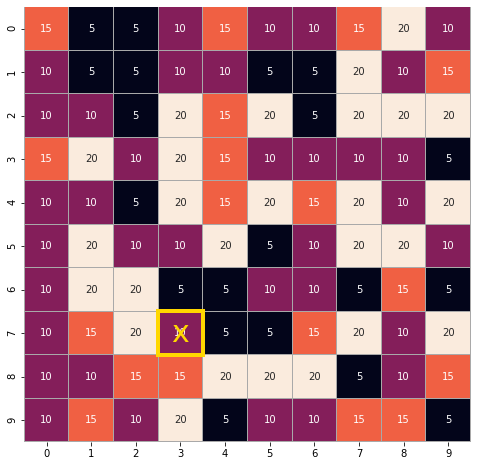

 One step estimation: 
Total actions= 67
Time: 0.024161577224731445
Terrain of Target: 1


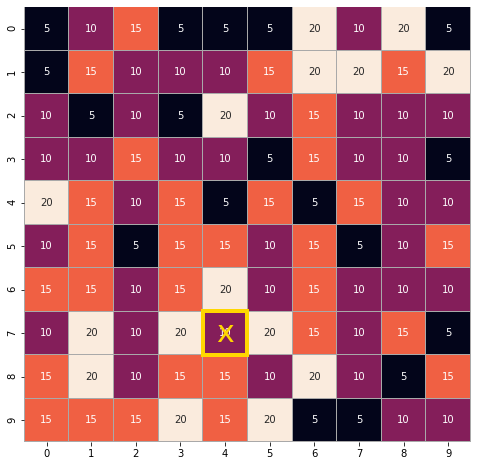

 One step estimation: 
Total actions= 179
Time: 0.0574038028717041
Terrain of Target: 2


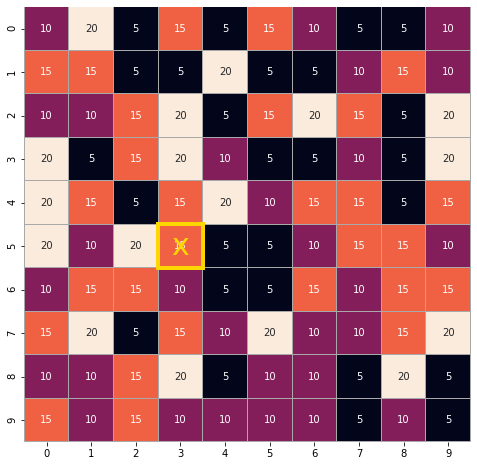

 One step estimation: 
Total actions= 617
Time: 0.18668341636657715
Terrain of Target: 1


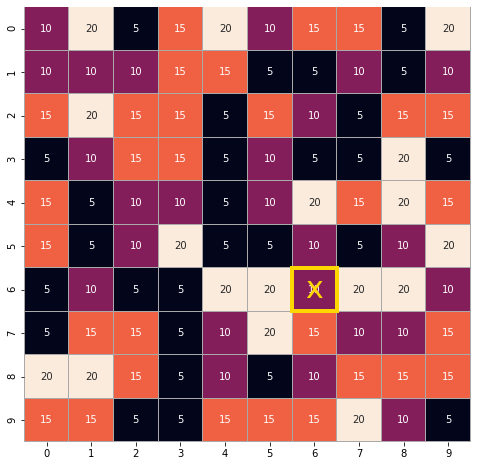

 One step estimation: 
Total actions= 323
Time: 0.09787368774414062
Terrain of Target: 1


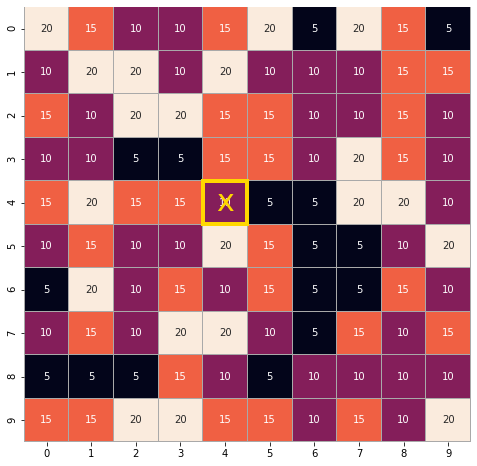

 One step estimation: 
Total actions= 33
Time: 0.009664297103881836
Terrain of Target: 3


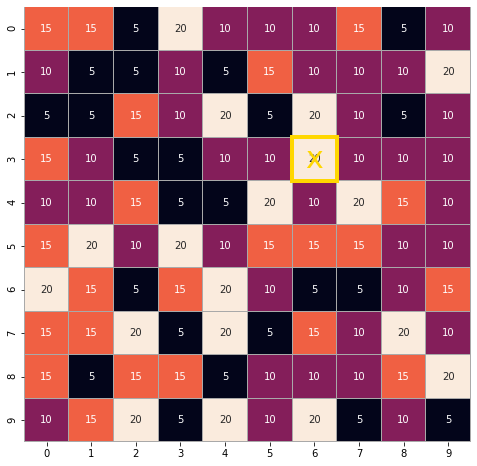

 One step estimation: 
Total actions= 529
Time: 0.1570265293121338
Terrain of Target: 1


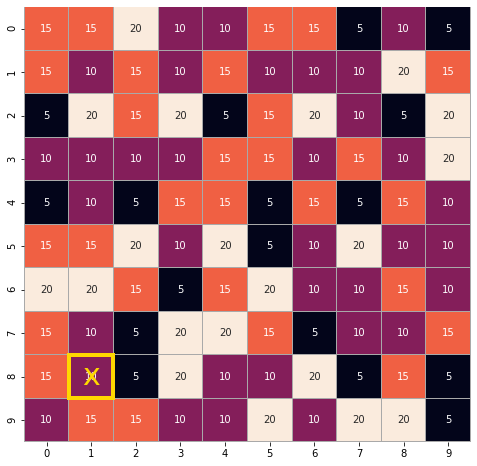

 One step estimation: 
Total actions= 485
Time: 0.14259719848632812
Terrain of Target: 1


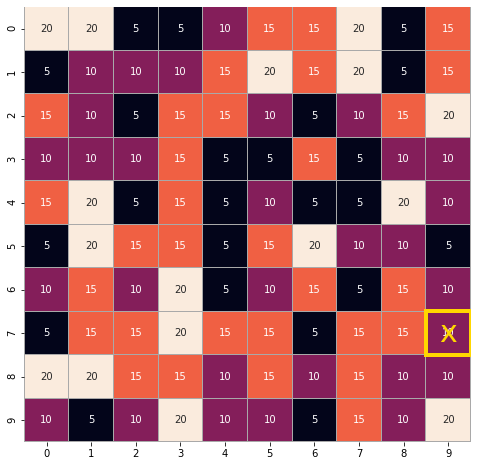

 One step estimation: 
Total actions= 323
Time: 0.09607243537902832
Terrain of Target: 0


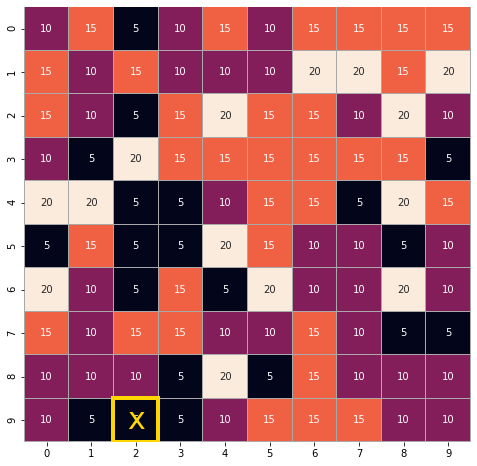

 One step estimation: 
Total actions= 277
Time: 0.08093523979187012
Terrain of Target: 1


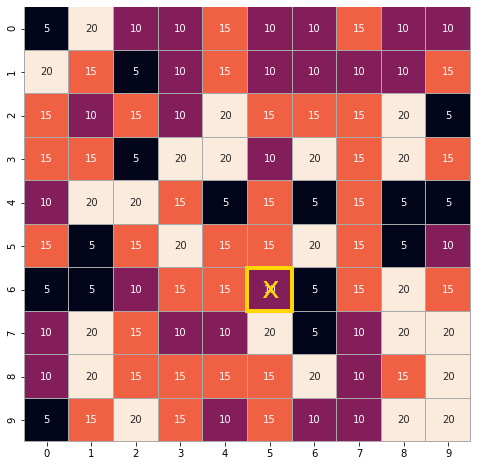

 One step estimation: 
Total actions= 79
Time: 0.025468111038208008
Terrain of Target: 1


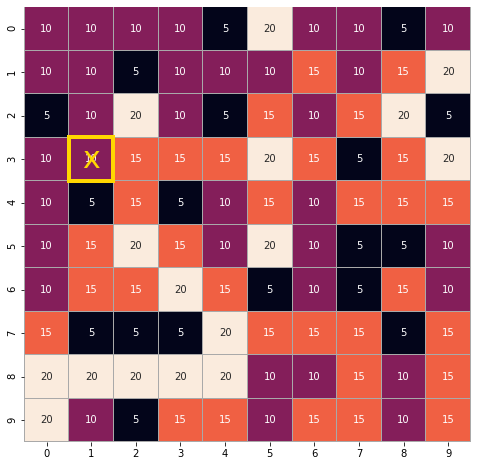

 One step estimation: 
Total actions= 193
Time: 0.057582855224609375
Terrain of Target: 0


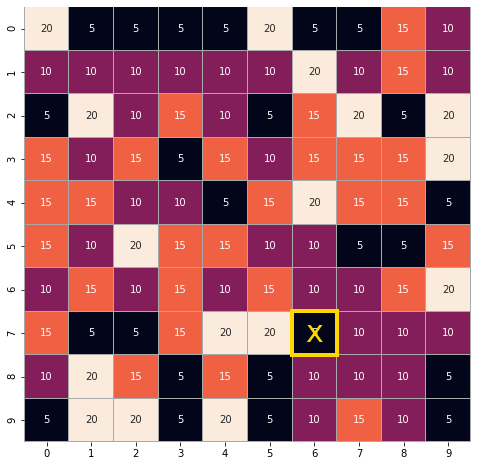

 One step estimation: 
Total actions= 125
Time: 0.04610323905944824
Terrain of Target: 3


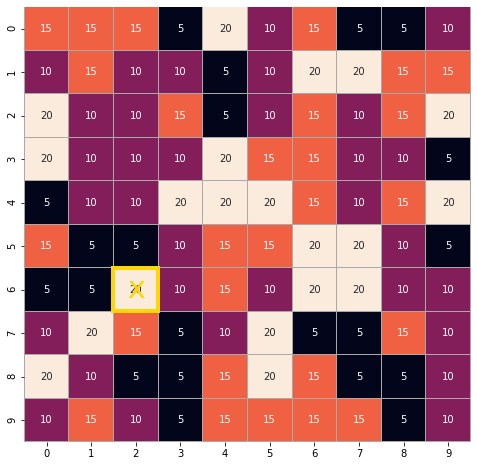

 One step estimation: 
Total actions= 681
Time: 0.21717453002929688
Terrain of Target: 2


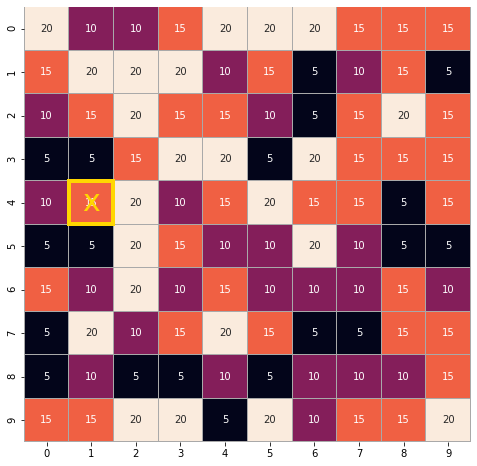

 One step estimation: 
Total actions= 83
Time: 0.028403282165527344
Terrain of Target: 2


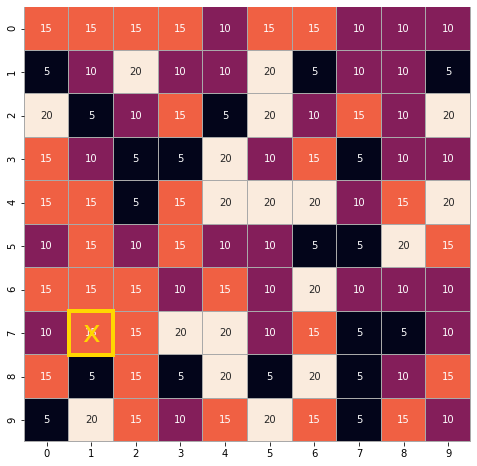

 One step estimation: 
Total actions= 1687
Time: 0.5592491626739502
Terrain of Target: 2


KeyboardInterrupt: ignored

In [0]:
a = 10

actions = []
start_time = time.time()
for i in range(10):
  environment = generate_environment(a)
  # Terrain type of target
  target = environment[1]
  terrain = np.int(environment[0][target]/5)-1
  print("Terrain of Target:", terrain)

  display_grid(environment)
  print(" One step estimation: ")
  start_time = time.time()
  total_actions = agent(environment,2)
  print("Total actions=",total_actions)
  print("Time:", time.time()- start_time)
  actions.append(total_actions)

  print(" Two step simplified estimation: ")
  start_time = time.time()
  total_actions = agent(environment,3)
  print("Total actions=",total_actions)
  print("Time:", time.time()- start_time)
  actions.append(total_actions)

print(actions)

##Analysis

Comparing the performance of selected cell based on minimum cost function values (two step and one step) and also the previous approaches of Rule 1 and Rule 2. We are taking the average number of actions required to find the target in each terrain.

In [0]:
def assign_terrain(a,terrain_type):

  # Terrain Type: 0 - Flat, 1 - Hilly, 2 - Forested, 3 - Caves
  env_terrains = np.zeros((a,a))

  flat_list = []
  hilly_list = []
  forest_list = []
  cave_list = []

  for i in range(a):
    for j in range(a):
      terrain = random.random()
      if terrain < 0.2:
        env_terrains[i, j] = 5 # Flat terrain with p = 0.2
        flat_list.append((i,j))
      elif terrain < 0.5:
        env_terrains[i, j] = 10 # Hilly terrain with p = 0.3
        hilly_list.append((i,j))
      elif terrain < 0.8:
        env_terrains[i, j] = 15 # Forested terrain with p = 0.3
        forest_list.append((i,j))
      else:
        env_terrains[i, j] = 20 # Maze of caves with p = 0.2
        cave_list.append((i,j))
  
  if terrain_type == 0:
    n = len(flat_list)
    index = random.randint(0,n-1)
    target_location = flat_list[index]
  elif terrain_type == 1:
    n = len(hilly_list)
    index = random.randint(0,n-1)
    target_location = hilly_list[index]
  elif terrain_type == 2:
    n = len(forest_list)
    index = random.randint(0,n-1)
    target_location = forest_list[index]
  elif terrain_type == 3:
    n = len(cave_list)
    index = random.randint(0,n-1)
    target_location = cave_list[index]

  environment = (env_terrains, target_location)
  return environment

In [0]:
def comparison_cost_functions(a, n_steps):

  df_one_step = pd.DataFrame(columns= ["terrain_type", "actions"], index = np.arange(0,4,1))
  df_two_step_simplified = pd.DataFrame(columns= ["terrain_type", "actions"], index = np.arange(0,4,1))
  # df_two_steps = pd.DataFrame(columns= ["terrain_type", "actions"], index = np.arange(0,4,1))
  df_rule_1 = pd.DataFrame(columns= ["terrain_type", "actions"], index = np.arange(0,4,1))
  df_rule_2 = pd.DataFrame(columns= ["terrain_type", "actions"], index = np.arange(0,4,1))


  # Iterating over terrain types
  for i in range(0,4):
    actions_sum_one = 0
    # actions_sum_two = 0
    actions_sum_two_simplified = 0
    actions_sum_rule_1 = 0
    actions_sum_rule_2 = 0

    print("Terrain", i)
    for j in range(n_steps):  
      environment = assign_terrain(a, i)
      
      actions_sum_one = actions_sum_one + agent(environment,2)
      # actions_sum_two = actions_sum_two + agent(environment,4)
      actions_sum_two_simplified = actions_sum_two_simplified + agent(environment,3)
      actions_sum_rule_1 = actions_sum_rule_1 + agent(environment,0)
      actions_sum_rule_2 = actions_sum_rule_2 + agent(environment,1)
      
    
    df_one_step.loc[i]["terrain_type"] = i
    df_one_step.loc[i]["actions"] = round(actions_sum_one/n_steps)
    # df_two_steps.loc[i]["terrain_type"] = i
    # df_two_steps.loc[i]["actions"] = round(actions_sum_two/n_steps)
    df_two_step_simplified.loc[i]["terrain_type"] = i
    df_two_step_simplified.loc[i]["actions"] = round(actions_sum_two_simplified/n_steps)
    df_rule_1.loc[i]["terrain_type"] = i
    df_rule_1.loc[i]["actions"] = round(actions_sum_rule_1/n_steps)
    df_rule_2.loc[i]["terrain_type"] = i
    df_rule_2.loc[i]["actions"] = round(actions_sum_rule_2/n_steps)
    
  return df_one_step, df_two_step_simplified, df_rule_1, df_rule_2

In [0]:
def plot_two_df(df_one_step, df_two_steps):

  x_text_dict = [ "Flat", "Hilly", "Forested", "Caves"]
  width = 0.35  
  terrain = np.arange(0,4,1)
  plt.bar( terrain+width , "actions", data = df_two_steps, label = "Cost(cell i, cell j)", width = 0.35)
  plt.bar( terrain , "actions", data = df_one_step, label = "Cost(cell i)", width = 0.35 )
  ax = plt.subplot(1, 1, 1)
  ax.set_xticks(np.arange(len(x_text_dict)))
  ax.set_xticklabels(x_text_dict)

  plt.legend(loc='best')
  plt.ylabel("Average #Actions")
  plt.xlabel("Terrain type")
  plt.show()

In [0]:
def plot_four_df(df_one_step, df_two_steps, df_rule_1, df_rule_2):

  x_text_dict = [ "Flat", "Hilly", "Forested", "Caves"]
  width = 0.15 
  terrain = np.arange(0,4,1)
  plt.bar( terrain , "actions", data = df_one_step, label = "Cost(cell i)", width = 0.15 )
  plt.bar( terrain+width , "actions", data = df_two_steps, label = "Cost(cell i, cell j)", width = 0.15)
  plt.bar( terrain+ 2*width , "actions", data = df_rule_1, label = "rule_1", width = 0.15)
  plt.bar( terrain + 3*width , "actions", data = df_rule_2, label = "rule_2", width = 0.15 )
  ax = plt.subplot(1, 1, 1)
  ax.set_xticks(np.arange(len(x_text_dict)))
  ax.set_xticklabels(x_text_dict)

  plt.legend(loc='best')
  plt.ylabel("Average #Actions")
  plt.xlabel("Terrain type")
  plt.show()

##Comapring the performance of the four decisions rules

In [0]:
df_one_step, df_two_steps, df_rule_1, df_rule_2 = comparison_cost_functions(10,10)
print(df_one_step)
print(df_two_steps)
print(df_rule_1)
print(df_rule_2)
plot_four_df(df_one_step, df_two_steps, df_rule_1, df_rule_2)

In [0]:
# df_one_step, df_two_steps = comparison_cost_functions(5,25)
# print(df_one_step)
# print(df_two_steps)
# plot_df(df_one_step, df_two_steps)

#### Comparison of performance to the rule of simply always traveling to the next cell indicated by Rule 1 or Rule 2

#### Another trial approach

This is the first naive approach that we tried which defined cost of any other cell in the map as a function of the distance from the current cell and also the belief value of that cell. Once this cell with minimum cost is determined, we search for another cell which we can encounter on the way to the cell with minimum cost. This appraoch comes with the approach that the cost to explore a cell which is on the way of the minimum cost cell has an additional cost of only 1 (searching that cell). We select such a cell which has the cost value comparable to the cell with minimum cost (a threshold value of the difference between the cost values of cell under consideration and the minimum cost is chosen). We select only one such cell on the way. However, more than one cell can be chosen as long as it does not affect the overall cost (number of actions) more than certain steps.

In [0]:
def modified_approach(environment, belief_map, current_cell,false_negative_rate):
  
  env_grid = environment[0]
  a = env_grid.shape[0]

  num_row = current_cell[0]
  num_col = current_cell[1]

  cost_map = np.zeros((a,a))

  for i in range(a):
    for j in range(a):
      distance = abs(num_row-i) + abs(num_col-j)
      terrain = np.int((env_grid[i][j])/5)-1
      # print(terrain)
      false_negative_cell_opened = false_negative_rate[terrain]
      # print(false_negative_cell_opened)
      # print(belief_map[i][j])
      cost_map[i][j] = distance + math.sqrt((1/belief_map[i][j])*(1-false_negative_cell_opened))
  
  cell_index = np.unravel_index(np.argmin(cost_map, axis=None), cost_map.shape)
  distance = abs(num_row - cell_index[0]) + abs(num_col - cell_index[1])
  max_cells = math.ceil(math.ceil(distance/2)/2)
  min_cost = cost_map[cell_index]
  thresh = 0.1*(min_cost)

  cells = []
  for i in range(min(cell_index[0], num_row), max(cell_index[0], num_row)):
    for j in range(min(cell_index[1], num_col), max(cell_index[1], num_col)):
      if cost_map[i][j] - min_cost < thresh:
        cells.append(((i,j), abs(num_row - i) + abs(num_col - j)))
  
  cells = sorted(cells, key = itemgetter(1))
  # cell_list = [cells.pop(0)]
  while len(cells) > 0:
    cell = cells.pop(0)
    
  cost = abs(cell_index[0]-i) + abs(cell_index[1]-j)

  return cell_index, cost

In [0]:
def modified_agent(environment):

  env_grid = environment[0]
  target_location = environment[1]
  a = env_grid.shape[0]

  target = environment[1]
  terrain = np.int(environment[0][target]/5)-1
  print("Terrain of Target:", terrain)
  initial_belief = 1/(a*a)
  belief_map = np.full((a,a), initial_belief)
  #print("Initial Belief map:")
  #display_grid((belief_map, target ))

  false_negative_rate = [0.1, 0.3, 0.7, 0.9]
  total_actions = 0

  dim = env_grid.shape[0] - 1
  i = random.randint(0,dim)
  j = random.randint(0,dim)

  current_cell = (i,j)

  while(True): 

    current_cells, cost = modified_approach(environment,belief_map,current_cell,false_negative_rate)
    # print(cost)
    #print("cell to be searched:", cell)
    while len(current_cells) > 0:
      current_cell = current_cells.pop()
      is_target = search_cell(environment, current_cell)
      total_actions = total_actions + cost + 1

    if(is_target):
      print("Success!")
      print("Number of actions = ", total_actions)
      return total_actions
    else:
      belief_map = update_belief(environment, belief_map, current_cell , false_negative_rate) 

In [0]:
a = 10
environment = generate_environment(a)
# Terrain type of target
target = environment[1]
terrain = np.int(environment[0][target]/5)-1
print("Terrain of Target:", terrain)

display_grid(environment)
start_time = time.time()
modified_agent(environment)
print("Time:", time.time()- start_time)